
# Importing TensorFlow and Required Libraries:

This code snippet imports TensorFlow as tf along with other necessary libraries for image processing and visualization tasks

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

# Setting Random Seed for Reproducibility:

This code snippet sets a random seed (seed) to ensure reproducibility of random number generation across different runs of the code. By fixing the random seed, the sequence of random numbers generated by NumPy's random number generator (np.random) will remain consistent across run

In [ ]:
seed = 42
np.random.seed = seed


# Setting Image Dimensions:

This code snippet defines the dimensions for preprocessing images in the machine learning pipeline

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


# Data Loading and Preprocessing:

This code snippet loads and preprocesses image data for a machine learning task using TensorFlow. It performs the following steps:

# Mounting Google Drive:

The code mounts the Google Drive to access data stored in specified directories.
# Defining File Paths and IDs:

File paths for training (TRAIN_PATH) and test (TEST_PATH) data are specified.
Unique identifiers (IDs) for training and test samples are obtained using os.walk().
# Initializing Arrays for Data Storage:

Arrays X_train and Y_train are initialized to store resized training images and corresponding masks, respectively.
Array X_test is initialized to store resized test images.
# Resizing and Preprocessing Images:

For each training sample, the code loads the image and its corresponding masks, resizes them to the specified dimensions (IMG_HEIGHT, IMG_WIDTH), and stores them in the respective arrays (X_train, Y_train).
For each test sample, the code loads and resizes the test images, storing them in the X_test array.
# Printing Status Updates:

Status updates are printed during the resizing and preprocessing steps to track progress.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



TRAIN_PATH = '/content/drive/MyDrive/DL_Project/stage1_train/'
TEST_PATH =  '/content/drive/MyDrive/DL_Project/stage1_test/'


train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')



Mounted at /content/drive


  0%|          | 0/114 [00:00<?, ?it/s]

Resizing training images and masks


  0%|          | 0/65 [00:00<?, ?it/s]

Resizing test images


100%|██████████| 65/65 [00:39<00:00,  1.65it/s]

Done!



# Building W-Net Model:

This code snippet constructs a W-Net model architecture, a modified version of the U-Net for image segmentation tasks. Here's a summary:

# Input Layer:

The input layer (inputs) is defined with dimensions (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS) to accommodate image data.
# Normalization:

A lambda layer (Lambda) is used to normalize input pixel values by dividing by 255, converting them to floating-point values.
# Encoding Path:

Four convolutional blocks (c2, c3, c4, c5) with increasing filter sizes are used for feature extraction, each followed by dropout and another convolutional layer.
Max-pooling layers (MaxPooling2D) are applied to down-sample feature maps.
# Decoding Path:

Transposed convolutional layers (Conv2DTranspose) are used for up-sampling feature maps to recover spatial resolution.
Concatenation (concatenate) with corresponding feature maps from the encoding path enhances skip connections.
Convolutional blocks (c6, c7, c8, c9) with decreasing filter sizes are employed for feature refinement, each followed by dropout and another convolutional layer.
# Other Part of W-Net:

An additional encoding-decoding path is introduced (commented out in the code snippet) to further enhance the feature representation and spatial resolution recovery.
# Output Layer:

The final convolutional layer (Conv2D) with sigmoid activation generates segmentation masks.
# Model Compilation:

The model is compiled using the Adam optimizer and binary cross-entropy loss, with accuracy as the evaluation metric.
#Model Summary:

The architecture and parameters of the constructed W-Net model are summarized using the summary() method.

In [ ]:
#Building W-Net Model

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # converting inputs values to floating point

"""
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(c1)
p1 = tf.keras.layers.MaxPool2D (2,2)(c1)
"""


c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# Other part of W-Net

c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
p9 = tf.keras.layers.MaxPooling2D((2, 2))(c9)

c10 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p9)
c10 = tf.keras.layers.Dropout(0.2)(c10)
c10 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
p10 = tf.keras.layers.MaxPooling2D((2, 2))(c10)

c11 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p10)
c11 = tf.keras.layers.Dropout(0.2)(c11)
c11 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
p11 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c11)

c12 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p11)
c12 = tf.keras.layers.Dropout(0.3)(c12)
c12 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c12)

#Expansive path
u13 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c12)
u13 = tf.keras.layers.concatenate([u13, c11])
c13 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u13)
c13 = tf.keras.layers.Dropout(0.2)(c13)
c13 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c13)

u14 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c13)
u14 = tf.keras.layers.concatenate([u14, c10])
c14 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u14)
c14 = tf.keras.layers.Dropout(0.2)(c14)
c14 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c14)

u15 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c14)
u15 = tf.keras.layers.concatenate([u15, c9])
c15 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u15)
c15 = tf.keras.layers.Dropout(0.1)(c15)
c15 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c15)
"""
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
"""
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c15)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           conv2d[0][0]                     
______________________________________________________________________________________________

#Model Training and Evaluation:

This code snippet demonstrates the process of training a neural network model for nuclei segmentation using training data (X_train, Y_train) and evaluating its performance on validation and test datasets. Here's a breakdown:

#Model Checkpoint and Callbacks:

A ModelCheckpoint callback is defined to save the best-performing model during training.
Additional callbacks, including EarlyStopping and TensorBoard, are also utilized for monitoring and logging training progress.
#Model Training:

The fit method is called on the model with training data (X_train, Y_train).
Training is performed with a validation split of 0.1, a batch size of 16, and for 30 epochs.
Callbacks defined earlier are passed to monitor and control the training process.
#Prediction:

The trained model is used to make predictions on the training, validation, and test datasets.
Predictions are obtained for both segmented masks (preds_train, preds_val, preds_test) and thresholded masks (preds_train_t, preds_val_t, preds_test_t) using a threshold of 0.5.
#Visualization:

Random samples from the training and validation datasets are selected for a sanity check.
Original images (X_train), ground truth masks (Y_train), and predicted masks (preds_train_t, preds_val_t) are visualized to assess the model's performance qualitatively.

Epoch 1/30
7/7 [==============================] - 39s 741ms/step - loss: 0.7028 - accuracy: 0.6896 - val_loss: 0.6150 - val_accuracy: 0.7627
Epoch 2/30
7/7 [==============================] - 1s 123ms/step - loss: 0.6215 - accuracy: 0.7964 - val_loss: 0.5797 - val_accuracy: 0.7627
Epoch 3/30
7/7 [==============================] - 1s 124ms/step - loss: 0.5852 - accuracy: 0.7964 - val_loss: 0.5437 - val_accuracy: 0.7627
Epoch 4/30
7/7 [==============================] - 1s 124ms/step - loss: 0.5048 - accuracy: 0.7964 - val_loss: 0.4742 - val_accuracy: 0.7627
Epoch 5/30
7/7 [==============================] - 1s 124ms/step - loss: 0.3946 - accuracy: 0.7964 - val_loss: 0.4394 - val_accuracy: 0.7627
Epoch 6/30
7/7 [==============================] - 1s 123ms/step - loss: 0.3376 - accuracy: 0.7964 - val_loss: 0.4693 - val_accuracy: 0.7627
Epoch 7/30
7/7 [==============================] - 1s 124ms/step - loss: 0.2977 - accuracy: 0.8068 - val_loss: 0.2963 - val_accuracy: 0.8599
Epoch 8/30
7/7 [===

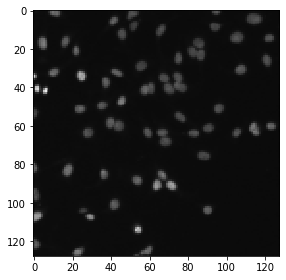

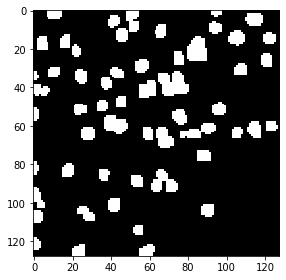

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


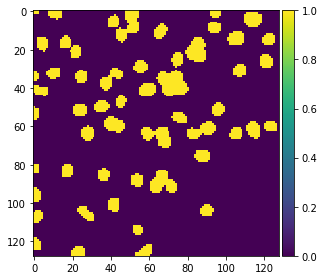

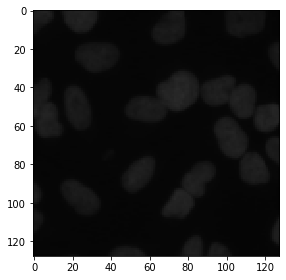

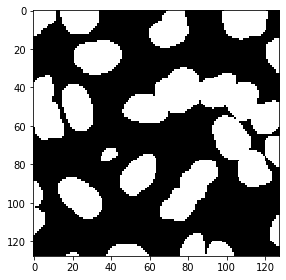

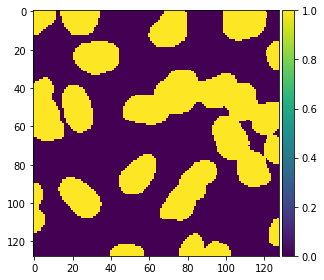

In [ ]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=30, callbacks=callbacks)

####################################

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()